# Comparing images from various datasets

## Setup

In [2]:
from google.colab import drive
import os, sys, subprocess
from pathlib import Path
import numpy as np
import PIL, gdal
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
Path.ls = lambda x: list(x.iterdir())
dir_mydrive = Path('/content/drive/My Drive')
dir_project = dir_mydrive/'omdena_engie'
dir_sg = (dir_mydrive/'Official Folder for Engie project'/
          'Data'/'Satellite Imagery'/'Main Island'/'JPEG_tiles_Main')

## Useful functions

In [5]:
def convert_to_8Bit(inputRaster, outputRaster,
                           outputPixType='Byte',
                           outputFormat='GTiff',
                           rescale_type='rescale',
                           percentiles=[2, 98]):
    '''
    Convert 16bit image to 8bit
    rescale_type = [clip, rescale]
        if clip, scaling is done strictly between 0 65535 
        if rescale, each band is rescaled to a min and max 
        set by percentiles
    '''    
    srcRaster = gdal.Open(inputRaster)
    cmd = ['gdal_translate', '-ot', outputPixType, '-of', 
           outputFormat]
    
    # iterate through bands
    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        if rescale_type == 'rescale':
            bmin = band.GetMinimum()        
            bmax = band.GetMaximum()
            # if not exist minimum and maximum values
            if bmin is None or bmax is None:
                (bmin, bmax) = band.ComputeRasterMinMax(1)
            # else, rescale
            band_arr_tmp = band.ReadAsArray()
            bmin = np.percentile(band_arr_tmp.flatten(), percentiles[0])
            bmax= np.percentile(band_arr_tmp.flatten(), percentiles[1])        
        else:
            bmin, bmax = 0, 65535        
                
        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(bmin))
        cmd.append('{}'.format(bmax))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))    

    cmd.append(inputRaster)
    cmd.append(outputRaster)
    print("Conversin command:", cmd)
    subprocess.call(cmd)

## Load images from the datasets

### Load a Singapore tile.

In [6]:
dir_sg/'main_9600_11600.jpeg' in dir_sg.ls()

True

In [7]:
im_sg = np.array(PIL.Image.open(dir_sg/'main_9600_11600.jpeg'))
im_sg.shape, im_sg.dtype

((512, 512, 3), dtype('uint8'))

### Load an xview2 image (0.3 m resolution)

In [8]:
im_xview2 = np.array(PIL.Image.open(dir_project/'190814-O-ZZ999-221.JPG'))
im_xview2.shape, im_xview2.dtype

((1430, 1432, 3), dtype('uint8'))

### Load a SpacenetV2 image (supposedly 0.3 m resolution).

In [9]:
dir_spacenet_raw = (dir_mydrive/'Official Folder for Engie project'/
                    'task_6_image-resolution'/'SpaceNet raw data')
places = ((4, 'Shanghai'), (3, 'Paris'), (2, 'Vegas'), (5, 'Khartoum'))

In [10]:
aoi, name = places[2]
dir_place = (dir_spacenet_raw/f'AOI_{aoi}_{name}_Train'/'RGB-PanSharpen')

In [11]:
[n.name for n in dir_place.ls()]

['RGB-PanSharpen_AOI_2_Vegas_img2636.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img5184.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img802.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1488.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img246.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1385.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img5874.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img225.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1265.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img2144.tif']

In [12]:
imid = 5184
convert_to_8Bit(str(dir_place/f'RGB-PanSharpen_AOI_{aoi}_{name}_img{imid}.tif'), 
                'test_8bit.tif', 
                rescale_type='rescale', percentiles=[1, 99])

Conversin command: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-scale_1', '111.0', '905.0100000000093', '0', '255', '-scale_2', '274.0', '1211.0', '0', '255', '-scale_3', '246.0', '819.0', '0', '255', '/content/drive/My Drive/Official Folder for Engie project/task_6_image-resolution/SpaceNet raw data/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img5184.tif', 'test_8bit.tif']


In [13]:
im_spacenet = np.array(PIL.Image.open('test_8bit.tif'))
im_spacenet.shape, im_spacenet.dtype

((650, 650, 3), dtype('uint8'))

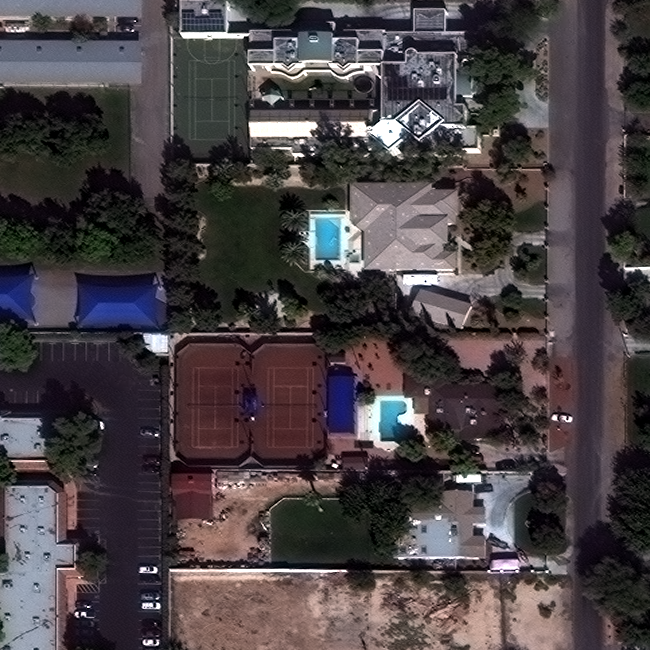

In [14]:
PIL.Image.fromarray(im_spacenet)

### Load a NZ Land (.1 m resolution)

In [16]:
dir_nz = dir_project/'lds-wellington-010m-urban-aerial-photos-2017-JPEG'

In [19]:
dir_nz.ls()[:3]

[PosixPath('/content/drive/My Drive/omdena_engie/lds-wellington-010m-urban-aerial-photos-2017-JPEG/BQ31_500_026066.jpg.aux.xml'),
 PosixPath('/content/drive/My Drive/omdena_engie/lds-wellington-010m-urban-aerial-photos-2017-JPEG/BQ31_500_018083.jgw'),
 PosixPath('/content/drive/My Drive/omdena_engie/lds-wellington-010m-urban-aerial-photos-2017-JPEG/BQ31_500_003091.jpg')]

In [20]:
im_nz = np.array(PIL.Image.open(dir_nz/'BQ31_500_042079.jpg'))
im_nz.shape, im_nz.dtype

((3600, 2400, 3), dtype('uint8'))

## Comparisons

### 512 px $\times$ 512 px patch 

What distance is covered by a pixel?  A car is about 2-3 metres.

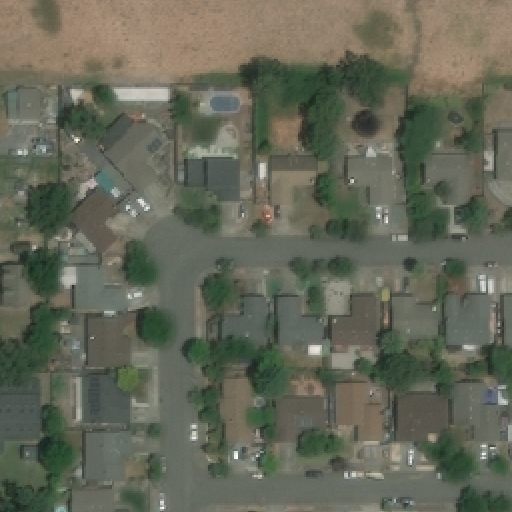

In [21]:
# xview2 (0.3 m)
PIL.Image.fromarray(im_xview2[100:100 + 512,:512])

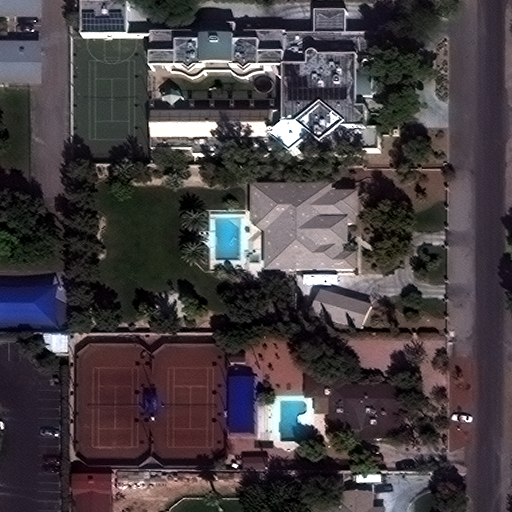

In [22]:
# SpacenetV2 (0.3 m)
PIL.Image.fromarray(im_spacenet[:512,100:100 + 512])

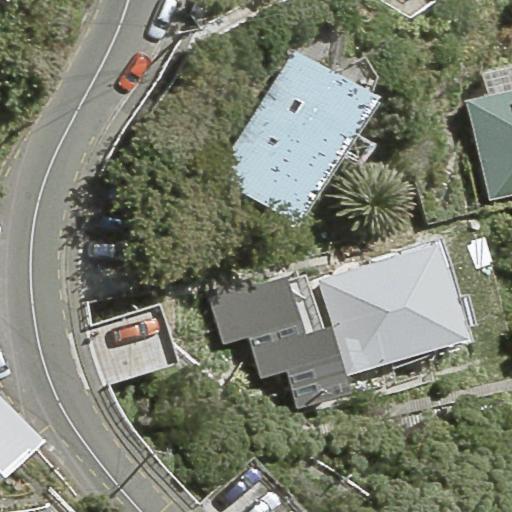

In [23]:
# NZ (0.1 m)
PIL.Image.fromarray(im_nz[1100:1100+512,150:150+512])

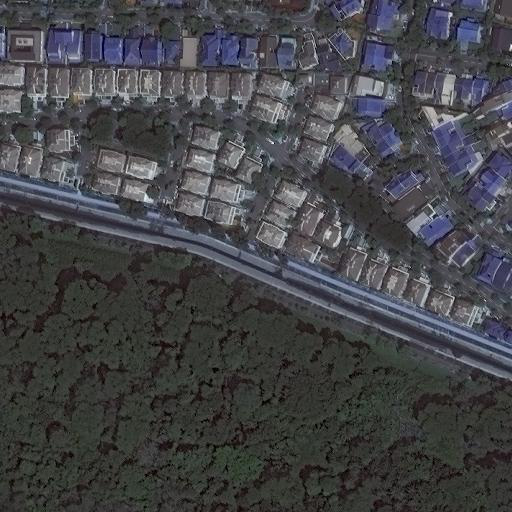

In [24]:
# Singapore 
PIL.Image.fromarray(im_sg)

### 'Detached house' comparison

How does the average house appear in a same-sized plot area on the computer screen?

In [25]:
imgs = [('xview2', im_xview2[240:320,170:250]),
        ('spacenet', im_spacenet[170:300,330:460]),
        ('nz', im_nz[1300:1500,450:650]),
        ('sg', im_sg[23:66,43:87])]

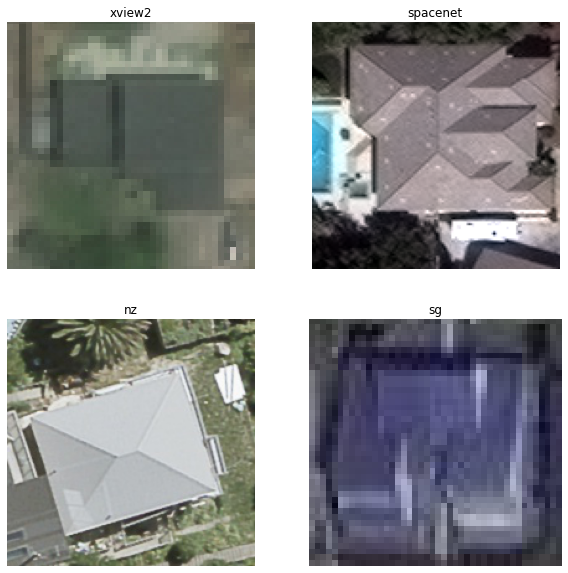

In [26]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = axs.flatten()
for ax, (setname, im) in zip(axs, imgs):
  ax.imshow(im)
  ax.set_title(f'{setname}')
  ax.axis('off');

## Reference

- [Land Information New Zealand](https://data.linz.govt.nz/set/4702-nz-aerial-imagery/)
- [Creating Training Datasets for the SpaceNet Road Detection and Routing Challenge](https://medium.com/the-downlinq/creating-training-datasets-for-the-spacenet-road-detection-and-routing-challenge-6f970d413e2f)
- [xView2: Assess Building Damage](https://xview2.org/)